Enter ticker (default SPY):  SPY


Fetching option chain for SPY …


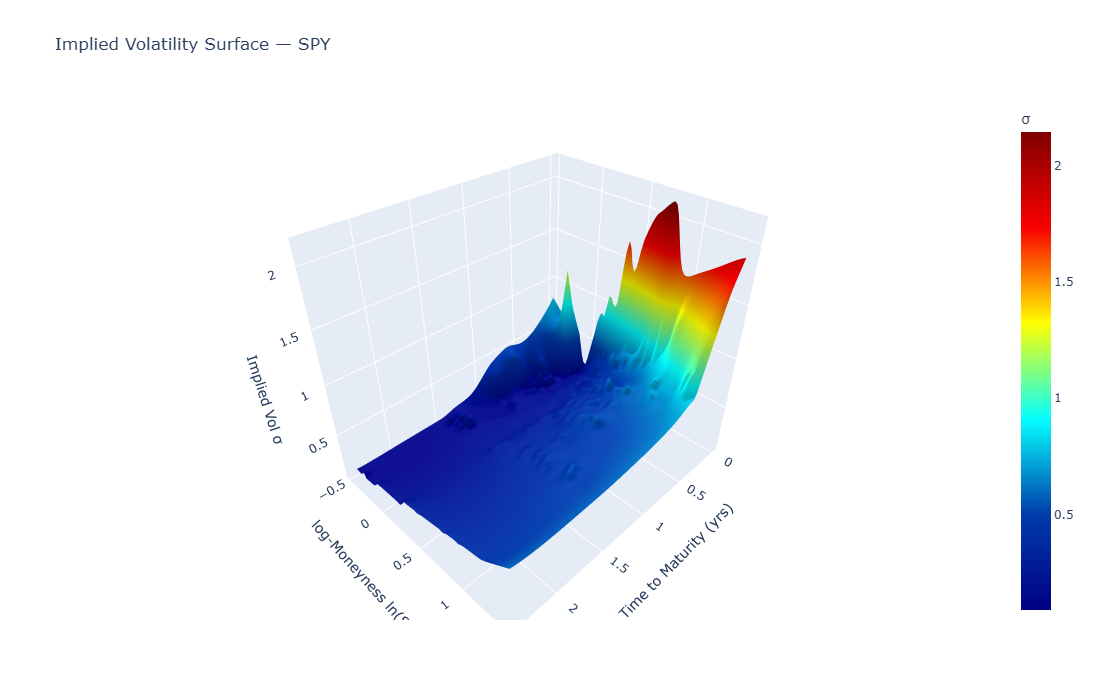

Data points used: 5,864


In [4]:
from __future__ import annotations
import sys, warnings
from typing import Literal
import numpy as np, pandas as pd, yfinance as yf
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.interpolate import Rbf, LinearNDInterpolator
import plotly.graph_objects as go

try:
    import streamlit as st
    _HAS_STREAMLIT = True
except ModuleNotFoundError:
    _HAS_STREAMLIT = False

GRID_SIZE              = 80
IV_MIN, IV_MAX         = 0.05, 2.0
BID_ASK_SPREAD_LIMIT   = 0.25
MIN_VOLUME             = 1
RBF_FUNC, RBF_SMOOTH   = "multiquadric", 0.2
RISK_FREE_RATE         = 0.05
DIV_YIELD              = 0.0
ALIASES = {"SPX": "^GSPC", "VIX": "^VIX", "RUT": "^RUT"}


def _bs_price(cp: Literal["c","p"], S, K, T, r, q, sigma):
    if T<=0 or sigma<=0:
        return max(0.0, S-K if cp=="c" else K-S)
    d1 = (np.log(S/K)+(r-q+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if cp=="c":
        return np.exp(-q*T)*S*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    return np.exp(-r*T)*K*norm.cdf(-d2) - np.exp(-q*T)*S*norm.cdf(-d1)

def _impl_vol_scalar(cp,S,K,T,r,q,price):
    intrinsic = max(0.0, S-K if cp=="c" else K-S)
    if price<=intrinsic or T<=0:
        return np.nan
    f=lambda sig:_bs_price(cp,S,K,T,r,q,sig)-price
    try:
        return brentq(f,1e-4,5.0,rtol=1e-6,maxiter=100)
    except Exception:
        return np.nan

implied_vol = np.vectorize(_impl_vol_scalar, otypes=[float])


def _get_spot(symbol:str)->float:
    yf_symbol = ALIASES.get(symbol.upper(),symbol)
    tk = yf.Ticker(yf_symbol)
    hist = tk.history(period="1d")
    if not hist.empty:
        return float(hist["Close"].iloc[-1])
    fast = getattr(tk,"fast_info",{})
    if fast.get("lastPrice"):
        return fast["lastPrice"]
    info = tk.info or {}
    if info.get("regularMarketPrice"):
        return info["regularMarketPrice"]
    raise RuntimeError("cannot fetch spot")

def fetch_option_chain(symbol:str)->pd.DataFrame:
    yf_symbol = ALIASES.get(symbol.upper(),symbol)
    tk = yf.Ticker(yf_symbol)
    spot = _get_spot(symbol)
    frames=[]
    for exp in tk.options or []:
        try:
            oc = tk.option_chain(exp)
        except Exception as e:
            warnings.warn(f"skip {exp}: {e}")
            continue
        for df,cp in ((oc.calls,"c"),(oc.puts,"p")):
            if df is None or df.empty:
                continue
            df=df.copy()
            df["mid"]=np.where((df["bid"]>0)&(df["ask"]>0),
                               (df["bid"]+df["ask"])/2,
                               df["lastPrice"])
            df["type"]=cp
            df["expiration"]=pd.to_datetime(exp,utc=True)
            df["spot"]=spot
            frames.append(df)
    if not frames:
        raise RuntimeError("no option data")
    return pd.concat(frames,ignore_index=True).rename(columns={"contractSymbol":"contract"})

def clean_chain(df:pd.DataFrame)->pd.DataFrame:
    today = pd.Timestamp.utcnow().normalize()
    df["T"] = (df["expiration"]-today).dt.total_seconds()/86400/365.0
    df = df.query("T>0 and strike>0")
    df = df[(df["volume"].fillna(0)>=MIN_VOLUME) &
            (df["mid"]>0) &
            (((df["ask"]-df["bid"]).abs()/df["mid"])<BID_ASK_SPREAD_LIMIT)]
    df["iv"] = implied_vol(df["type"].values, df["spot"].values,
                           df["strike"].values, df["T"].values,
                           RISK_FREE_RATE, DIV_YIELD, df["mid"].values)
    df = df[np.isfinite(df["iv"]) & (df["iv"]>IV_MIN) & (df["iv"]<IV_MAX)]
    df["M"] = np.log(df["spot"]/df["strike"])
    return df[["T","M","iv"]]

def build_iv_surface(symbol:str)->pd.DataFrame:
    return clean_chain(fetch_option_chain(symbol))


def interpolate_surface(data:pd.DataFrame, grid:int=GRID_SIZE):
    T_lin=np.linspace(data["T"].min(),data["T"].max(),grid)
    M_lin=np.linspace(data["M"].min(),data["M"].max(),grid)
    TT,MM=np.meshgrid(T_lin,M_lin)
    if len(data)<1000:
        interp=LinearNDInterpolator(data[["T","M"]].values,data["iv"].values,fill_value=np.nan)
        IV=interp(TT,MM)
    else:
        rbf=Rbf(data["T"].values,data["M"].values,data["iv"].values,
                function=RBF_FUNC,smooth=RBF_SMOOTH)
        IV=rbf(TT,MM)
    return TT,MM,IV

def plot_surface(TT,MM,IV,symbol):
    surf=go.Surface(x=TT,y=MM,z=IV,colorscale="Jet",showscale=True,
                    colorbar=dict(title="σ"))
    fig=go.Figure(data=[surf],layout=go.Layout(
        title=f"Implied Volatility Surface — {symbol.upper()}",
        scene=dict(xaxis_title="Time to Maturity (yrs)",
                   yaxis_title="log-Moneyness ln(S/K)",
                   zaxis_title="Implied Vol σ"),
        height=700))
    return fig


def _run_streamlit():
    st.set_page_config(layout="wide",page_title="IV Surface Viewer")
    st.markdown("<style>.stTextInput input{font-family:monospace;color:#39ff14;background:#000}</style>",unsafe_allow_html=True)
    st.title(":green[Live 3-D Implied Volatility Surface]")
    tkr = st.text_input("Enter ticker:", "SPY")
    if st.button("Render Surface",use_container_width=True):
        with st.spinner(f"Fetching option chain for {tkr.upper()} …"):
            try:
                data = build_iv_surface(tkr.upper())
            except Exception as e:
                st.error(str(e)); return
        if data.empty:
            st.warning("No data points – underlying likely illiquid."); return
        TT,MM,IV = interpolate_surface(data)
        st.plotly_chart(plot_surface(TT,MM,IV,tkr),use_container_width=True)
        st.caption(f"Data points used: {len(data):,}")

def _run_notebook_or_cli():
    try:
        from IPython.display import display
        import ipywidgets as w
        txt = w.Text(value="SPY",description="Ticker:")
        btn = w.Button(description="Render")
        out = w.Output()
        def click(_):
            with out:
                out.clear_output()
                sym = txt.value.strip().upper() or "SPY"
                print(f"Fetching option chain for {sym} …")
                try:
                    data = build_iv_surface(sym)
                except Exception as e:
                    print("Error:",e); return
                if data.empty:
                    print("No data points – underlying likely illiquid."); return
                TT,MM,IV = interpolate_surface(data)
                fig = plot_surface(TT,MM,IV,sym)
                fig.show()
                print(f"Data points used: {len(data):,}")
        btn.on_click(click)
        display(txt,btn,out)
    except Exception:
        sym = input("Enter ticker (default SPY): ").strip().upper() or "SPY"
        print(f"Fetching option chain for {sym} …")
        try:
            data = build_iv_surface(sym)
        except Exception as e:
            print("Error:",e); sys.exit(1)
        if data.empty:
            print("No data points – underlying likely illiquid."); sys.exit(0)
        TT,MM,IV = interpolate_surface(data)
        plot_surface(TT,MM,IV,sym).show()
        print(f"Data points used: {len(data):,}")


if __name__ == "__main__":
    _run_streamlit()
